In [1]:
#clean the notebook and erase all variables
%reset -f

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from pprint import pprint
from os import listdir
import datetime

np.set_printoptions(precision=2,suppress=True,linewidth=50000)

# Import the data

In [12]:
"""
functions
"""
def load_dico(path,key_int=False,print_me=False):
    with open(path) as f:
        dico_str = json.loads(json.load(f))

    if key_int:
        conv_key=lambda k:int(k)
    else:
        conv_key=lambda k:k

    dico={conv_key(k):v for k,v in dico_str.items()}

    if print_me:
        print(dico)

    return dico


class classCLASS:

    def __init__(self,id,name,behaviors,sampling_weight=1,loss_weight=1):
        self.id=id
        self.name=name
        self.behaviors=behaviors
        self.sampling_weight=sampling_weight
        self.loss_weight=loss_weight

In [3]:
""" a dictionary to store all the information """
memo=pd.Series()

In [9]:
#Path to the folder containing the Hawksbill dataset downloaded from Zenodo
DIR_IN="/mnt/c/Users/loren/Documents/Articles/github/Data_GT_preprocessed" 
DIR_IN="c:/Users/loren/Documents/Articles/github/Data_GT_preprocessed" 

In [6]:
#Split the data into training/validation/testing dataset based on the individuals

NAMES_TRAIN=memo["NAMES_TRAIN"]=[
                     'CC-07-48_18-02-2019',#10
                     'CC-07-48_06-10-2018',#6
                     'CC-07-48_04-10-2018',#5
                     'CC-07-115_13-05-2019',#3
                     'CC-07-115_14-05-2019',#3
                     'CC-07-48_08-04-2019_1', #7
                     'CC-07-48_08-04-2019_2', #7
                     'CC-07-48_08-04-2019_3', #7
                     'CC-07-48_22-05-2018', #121
                      'CC-07-108_11-02-2019', #

                    ]

NAMES_VAL=memo["NAMES_TEST"]=[
    'CC-07-59_20-05-2018', #13
    'CC-07-47_14-02-2018', #4
    'CC-07-48_10-10-2018'#9
    ]


NAMES_TEST=memo["NAMES_VAL"]=[
    'CC-07-48_08-10-2018',#8
    'CC-07-48_26-05-2018',#12
    'CC-07-107_11-02-2019' #1
    ]

NAMES_ALL=NAMES_TRAIN+NAMES_VAL+NAMES_TEST

In [10]:
dico_info_A=load_dico(DIR_IN+"/dico_info.json",print_me=True);


{'RESAMPLING_STEP_S': 0.05, 'col_names': ['Accelerometer X [m/s²]', 'Accelerometer Y [m/s²]', 'Accelerometer Z [m/s²]', 'Gyroscope X [mrad/s]', 'Gyroscope Y [mrad/s]', 'Gyroscope Z [mrad/s]', 'Depth [m]', 'beh', 'beh_merge', 'StX', 'StY', 'StZ', 'DX', 'DY', 'DZ', 'VeDBA', 'Pressure_corr', 'Pressure_diff']}


In [13]:
CASE=memo["CASE"]="TestA" #give a different name if change parameter

#the Behavioral categories defined by classCLASS : id ,name of behavior ,behaviors number in the data csv, sampling_weight=1, loss_weight=1
Other=classCLASS(0,"Other",None,1,0.1)
Breathing=classCLASS(1,"Breathing",[1,2,40])
Feeding=classCLASS(2,"Feeding",[3,4,5,6,7,11,12,13,18,19,20,21],2,2)
Gliding=classCLASS(3,"Gliding",[16,17],3)
Resting=classCLASS(4,"Resting",[29,30,31,32],0.5)
Scratching=classCLASS(5,"Scratching",[34,35,36],2,2)
Swimming=classCLASS(6,"Swimming",[42,45,48,43,46,49,27,44,47,50,56,52,54,55],0.5)

CLASSES=[Other,Breathing,Feeding,Gliding,Resting,Scratching,Swimming]

DESCRIPTORS_SELEC=[0,1,2,3,4,5,17] #the variables selected to train the Vnet
WINDOW_DURA=40 #size of the window in seconds
RESAMPLING_STEP_S=0.0500 #freq of the csv files
WINDOW_SIZE=int(WINDOW_DURA/RESAMPLING_STEP_S) #size of the window and therefore input
COL_BEH=7


#Parameters of the Vnet
LR_initial=0.0001
BATCH_SIZE=32
MODEL_DEPTH=32
MODEL_HEAD="softmax"
DROPOUT=0.5

In [14]:
##check whcih variables we are going to use
DESC_NAMES=dico_info_A['col_names']
DESC_NAMES_SELEC=[]
for i,name in enumerate(DESC_NAMES):
    if i in DESCRIPTORS_SELEC:
        prefix=""
        DESC_NAMES_SELEC.append(name)
    else:
        prefix="-----suppressed----->"
    print(prefix,i,name)

 0 Accelerometer X [m/s²]
 1 Accelerometer Y [m/s²]
 2 Accelerometer Z [m/s²]
 3 Gyroscope X [mrad/s]
 4 Gyroscope Y [mrad/s]
 5 Gyroscope Z [mrad/s]
-----suppressed-----> 6 Depth [m]
-----suppressed-----> 7 beh
-----suppressed-----> 8 beh_merge
-----suppressed-----> 9 StX
-----suppressed-----> 10 StY
-----suppressed-----> 11 StZ
-----suppressed-----> 12 DX
-----suppressed-----> 13 DY
-----suppressed-----> 14 DZ
-----suppressed-----> 15 VeDBA
-----suppressed-----> 16 Pressure_corr
 17 Pressure_diff


In [15]:
#save everyhting in dictionary
memo["MODEL_HEAD"]=MODEL_HEAD

memo["MODEL_DEPTH"]=MODEL_DEPTH

memo["BATCH_SIZE"]=BATCH_SIZE
memo["LR_initial"]=LR_initial
memo["WINDOW_DURA"]=WINDOW_DURA

memo["DIR_IN"]=DIR_IN
memo["RESAMPLING_STEP_S"]=RESAMPLING_STEP_S
for CLASS in CLASSES:
    memo["CLASSES_"+CLASS.name]=CLASS.__dict__
memo["DROPOUT"]=DROPOUT
memo["DESCRIPTORS_SELEC"]=DESCRIPTORS_SELEC

## Load the data

In [16]:
def load_mat(names):
    matrices={}
    labels={}

    for name in names:
        full_name=DIR_IN+"/"+name+".npy"
        if not os.path.exists(full_name):
            assert 1==0,"the file:"+full_name+" cannot be found"
        else:
            full_mat=np.load(full_name)
            pre_label=full_mat[:,COL_BEH]

            label=np.zeros_like(pre_label)
            for CLASS in CLASSES:
                if CLASS!=Other:
                    for beh in CLASS.behaviors:
                        label[pre_label==beh]=CLASS.id


            #np.save(DIR_OUT+"/"+name+"=pre_label",pre_label)
            mat=full_mat[:,DESCRIPTORS_SELEC]
            print("loading the matrix:"+name)
            print("shape:",mat.shape)
            print("duration in seconds:",len(mat)*RESAMPLING_STEP_S)
            print("duration in hour:",round(len(mat)*RESAMPLING_STEP_S/60/60,2))
            print()
            matrices[name]=mat
            labels[name]=label

    return matrices,labels

    print("number of loaded matrices:",len(matrices))

In [17]:
Matrices,Labels=load_mat(NAMES_ALL)

loading the matrix:CC-07-48_18-02-2019
shape: (559219, 7)
duration in seconds: 27960.95
duration in hour: 7.77

loading the matrix:CC-07-48_06-10-2018
shape: (475183, 7)
duration in seconds: 23759.15
duration in hour: 6.6

loading the matrix:CC-07-48_04-10-2018
shape: (284021, 7)
duration in seconds: 14201.050000000001
duration in hour: 3.94

loading the matrix:CC-07-115_13-05-2019
shape: (731266, 7)
duration in seconds: 36563.3
duration in hour: 10.16

loading the matrix:CC-07-115_14-05-2019
shape: (325009, 7)
duration in seconds: 16250.45
duration in hour: 4.51

loading the matrix:CC-07-48_08-04-2019_1
shape: (157315, 7)
duration in seconds: 7865.75
duration in hour: 2.18

loading the matrix:CC-07-48_08-04-2019_2
shape: (88800, 7)
duration in seconds: 4440.0
duration in hour: 1.23

loading the matrix:CC-07-48_08-04-2019_3
shape: (142801, 7)
duration in seconds: 7140.05
duration in hour: 1.98

loading the matrix:CC-07-48_22-05-2018
shape: (286161, 7)
duration in seconds: 14308.0500000

## Vizualisation


In [18]:
def histoOneInd(matrix):
    nb_col=matrix.shape[1]
    fig,axs=plt.subplots(1,nb_col,figsize=(nb_col*3,2))
    #axs=axs.flatten(nb_col)
    for j in range(nb_col):
        axs[j].hist(matrix[:,j],bins=40,edgecolor='k')
        axs[j].set_title(DESC_NAMES_SELEC[j], color="coral")
        axs[j].tick_params(colors='coral')
    plt.show()

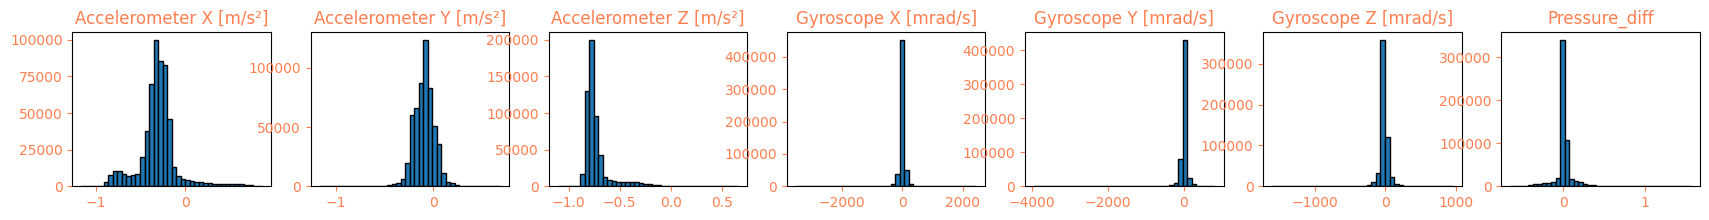

In [19]:
histoOneInd(Matrices[NAMES_TRAIN[0]])

In [20]:
def plotOneInd(name,deb=0,fin=-1):

    matrix=Matrices[name]
    label=Labels[name]
    nb_col=matrix.shape[1]

    fig,axs=plt.subplots(nb_col+1,1,figsize=(12,(nb_col+1)*2))

    axs[0].plot(label[deb:fin])
    for i in range(nb_col):

        axs[i+1].plot(matrix[deb:fin,i])
        axs[i+1].set_title(DESC_NAMES_SELEC[i])

    title=name+"_"+str(deb)+"->"+str(fin)
    fig.suptitle(title)

    fig.tight_layout()


    #fig.savefig(DIR_OUT+"/"+title)

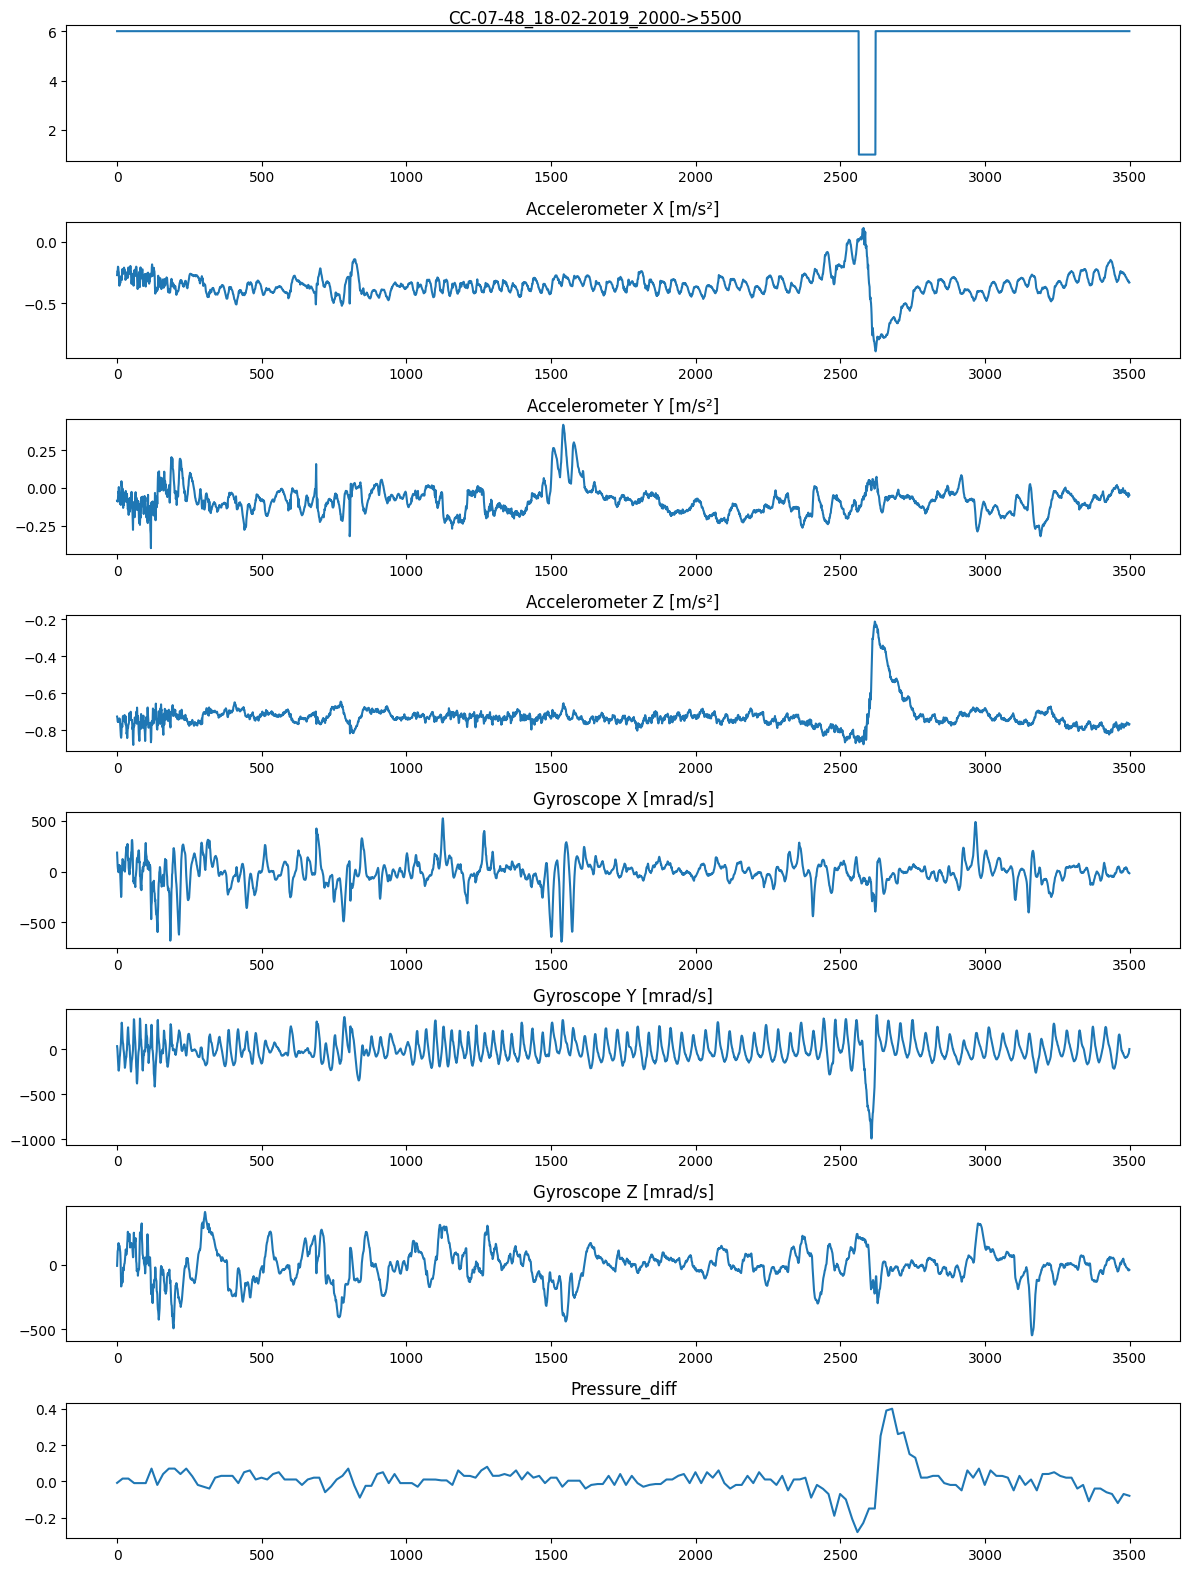

In [21]:
plotOneInd(NAMES_TRAIN[0],2000,5500)

## Normalization of the data

In [22]:
def normalize():

    nb_col=Matrices[NAMES_ALL[0]].shape[1]
    for matrix in Matrices.values():
        for j in range(nb_col):
            matrix[:,j]-=matrix[:,j].mean()
            matrix[:,j]/=matrix[:,j].std()



In [27]:
normalize()

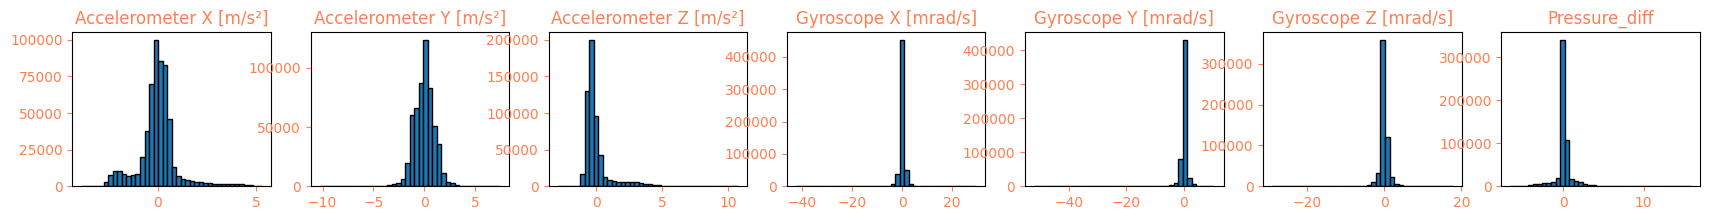

In [28]:
histoOneInd(Matrices[NAMES_TRAIN[0]])

# Create Folder with the date of today to save the predictions

In [24]:
now = datetime.datetime.now()
today=now.strftime("%Y_%m_%d")
today

'2024_06_11'

In [25]:
#Path of the folder where to save the model and predictions
DIR_OUT="c:/Users/loren/Documents/Articles/github/Model_results/model="+today+"_"+CASE
DIR_OUT

'c:/Users/loren/Documents/Articles/github/Model_results/model=2024_06_11_TestA'

In [26]:
"DANGER: THIS WILL CLEAR ALL SAVED WORK (except if the CASE or the day changes)"

import shutil
if os.path.exists(DIR_OUT):
    shutil.rmtree(DIR_OUT)
    print("we clear the directory:",DIR_OUT)
else:
    print("we create the directory:",DIR_OUT)

"""Creation of the folder """
os.makedirs(DIR_OUT)

we create the directory: c:/Users/loren/Documents/Articles/github/Model_results/model=2024_06_11_TestA


# Data Generator

In [30]:
def density_for_one_promotion(turtle_name, CLASS):

    label=Labels[turtle_name]

    N = len(label)
    dens = np.zeros_like(label)

    dens[label==CLASS.id] = 1

    sum_dens=np.sum(dens)
    if  sum_dens<1e-6:
        print("the class to promote:"+CLASS.name +" is not present in:"+turtle_name)
        dens[:]=1
        sum_dens=len(dens)


    dens/=sum_dens

    # creating a mask.
    kernel = np.ones(int(1.5*WINDOW_SIZE))
    kernel/=np.sum(kernel)
    #gauss = np.exp(-t**2)
    #gauss /= np.sum(gauss)

    # convolving label with a mask
    dens_conv = np.convolve(dens, kernel, mode='same')

    dens_conv[-WINDOW_SIZE//2-2:]=0
    dens_conv[:WINDOW_SIZE//2+2]=0

    cdf=np.cumsum(dens_conv)
    cdf/=cdf[-1]

    def rand_gene():
        while True:
                yield np.argmax(cdf>np.random.random())-WINDOW_SIZE//2

    return dens,dens_conv,cdf,rand_gene()

In [52]:
class InterestingTurtles:

    def __init__(self,turtle_names,CLASS):
        self.turtle_names=turtle_names
        self.occurences=np.zeros(len(turtle_names))
        self.CLASS=CLASS

        for i,name in enumerate(turtle_names):
            self.occurences[i]+=np.sum(Labels[name]==CLASS.id)

        self.proba=self.occurences/np.sum(self.occurences)

    def give_me_one_turtle(self):
        return np.random.choice(a=self.turtle_names,p=self.proba)

### Global generator
(See Jeantet et al. 2021 for details)\
The global generator draws a data window among the specified individuals (turtle_names), favoring a window that contains behaviors with a higher class.sampling_weight index. 10% of the windows are randomly selected without taking into account the sampling_weight index. 
In detail:  

* We draw a behavior (theClass) based on CLASS.sampling_weight
* We select a turtle (theTurtle) based on InterestingTurtles function which going to give a individual who express this behavior (higher probability if the individual express this behavior more than the other one)
* We draw a time window using the density_for_one_promotion generator associated with the turtle and the behavior.

In [31]:
class Global_generator:

    def __init__(self,turtle_names):

        self.turtle_names=turtle_names

        self.interesting_turtles_by_class={}

        self.proba_of_classes=np.zeros(len(CLASSES))

        for CLASS in CLASSES:
            self.interesting_turtles_by_class[CLASS.name]=InterestingTurtles(turtle_names,CLASS)
            self.proba_of_classes[CLASS.id]=CLASS.sampling_weight

        self.proba_of_classes/=np.sum(self.proba_of_classes)


        print([ (CLASS.name,self.proba_of_classes[CLASS.id]) for CLASS in CLASSES])


        self.class_2_index_gene={}

        for CLASS in CLASSES:

            random_index_generators={}
            for name in turtle_names:
                _,_,_,gene=density_for_one_promotion(name,CLASS)
                random_index_generators[name]=gene

            self.class_2_index_gene[CLASS.name]=random_index_generators



    def give_me_turtle_and_timeIndex(self):

        if np.random.rand()<0.1:
            theTurtle=np.random.choice(self.turtle_names)
            deb=0
            fin=len(Labels[theTurtle])-WINDOW_SIZE
            t=np.random.randint(deb,fin)
            return theTurtle,t

        theClass=np.random.choice(CLASSES,p=self.proba_of_classes)
        theTurtle=self.interesting_turtles_by_class[theClass.name].give_me_one_turtle()


        theGenerators=self.class_2_index_gene[theClass.name]
        theGenerator=theGenerators[theTurtle]
        return theTurtle,next(theGenerator)

In [33]:
def oneEpoch_generator_window(turtle_names, size=100):


    generator=Global_generator(turtle_names)

    while True:

        X = np.empty([size,WINDOW_SIZE,len(DESCRIPTORS_SELEC)])
        Y = np.empty([size,WINDOW_SIZE],dtype=int)

        for i in range(size):
            turtle_name,t=generator.give_me_turtle_and_timeIndex()
            matrix=Matrices[turtle_name]
            label=Labels[turtle_name]
            X[i,:,:]=matrix[t:t+WINDOW_SIZE ,:]
            Y[i,:]=label[t:t+WINDOW_SIZE]

        yield X, keras.utils.to_categorical(Y,len(CLASSES))


##### Histogram of the behavior distribution with global generator (for 2000 windows)

In [ ]:
global_generator=Global_generator(NAMES_ALL)

In [ ]:
res=[]
for i in range(2000):
    theTurtle,t=global_generator.give_me_turtle_and_timeIndex()
    window=Labels[theTurtle][t:t+WINDOW_SIZE]
    res.extend(window)

In [ ]:
bins=np.arange(len(CLASSES)+1)-0.5
plt.hist(res,bins,edgecolor="k",orientation='horizontal');
xtics=range(len(CLASSES))
xtics_label=[CLASS.name for CLASS in CLASSES]
plt.yticks(xtics,xtics_label)

# V-Net

In [34]:

import keras
import tensorflow as tf
from keras.layers import Conv1D,UpSampling1D,Add,SpatialDropout1D, BatchNormalization,Concatenate
import keras.layers as layers


In [36]:
class Vnet_4levels:

    def __init__(self):
        self.depth=MODEL_DEPTH
        self.dropout_rate=DROPOUT
        self.batch_norm=True
        self.padding="same"
        self.kernel_size=5


    def doubleConv(self, Y, depth,NAME=False):
        Y = Conv1D(depth, self.kernel_size, activation="relu", padding='same')(Y)
        if NAME==True:
            Y = Conv1D(depth, self.kernel_size, activation="relu", padding='same',use_bias=False,name='Last_conv')(Y)
        else:
            Y = Conv1D(depth, self.kernel_size, activation="relu", padding='same',use_bias=False)(Y)
        Y = BatchNormalization()(Y)
        Y = SpatialDropout1D(self.dropout_rate)(Y)
        return Y

    def makeUp(self,Y,depth):
        Y = UpSampling1D()(Y)
        return Conv1D(depth,2,activation="relu",padding = "same")(Y)



    def __call__(self,inputs):
        #PATCH_DIM
        conv_1 = self.doubleConv(inputs,self.depth)

        #PATCH_DIM/2
        down_1 = Conv1D(self.depth*2,2, strides=2, padding = "same", activation="relu")(conv_1)
        conv_2 = self.doubleConv(down_1,self.depth*2)

        #PATCH_DIM/4
        Y=Add()([down_1,conv_2])
        down_2 = Conv1D(self.depth*4, 2, strides=2, padding = "same", activation="relu")(Y)
        conv_3 = self.doubleConv(down_2,self.depth*4)

        #PATCH_DIM/8
        Y=Add()([down_2,conv_3])
        down_3 = Conv1D(self.depth*8, 2, strides=2, padding = "same", activation="relu")(Y)
        conv_4 = self.doubleConv(down_3,self.depth*8)

        #PATCH_DIM/4
        up_1=self.makeUp(conv_4,self.depth*4)
        Y = Add()([conv_3, up_1])
        pre_conv_5= self.doubleConv(Y,self.depth*4)
        conv_5=Add()([pre_conv_5,up_1])

        #PATCH_DIM/2
        up_2=self.makeUp(conv_5,self.depth*2)
        Y = Add()([conv_2, up_2])
        pre_conv_6= self.doubleConv(Y,self.depth*2)
        conv_6=Add()([pre_conv_6,up_2])

        #PATCH_DIM
        up_3=self.makeUp(conv_6,self.depth)
        Y = Add()([conv_1, up_3])
        pre_conv_7= self.doubleConv(Y,self.depth,NAME=True)
        conv_7=Add()([pre_conv_7,up_3])

        return conv_7

In [37]:
"""dummy data to test"""
nb_input=7
nb_output=2
window_size=600
batch_size=4
X=np.ones([batch_size,window_size,nb_input])

VNet=Vnet_4levels()
VNet.depth=1
inputs= keras.Input(shape=(window_size,nb_input))
outputs= VNet(inputs)

model_test = keras.Model(inputs=inputs, outputs=outputs)
Y_pred=model_test.predict(X)
Y_pred.shape


1/1 [==============================] - 1s 736ms/step


(4, 600, 1)

In [38]:
model_test.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 600, 7)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 600, 1)               36        ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 600, 1)               5         ['conv1d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 600, 1)               4         ['conv1d_1[0][0]']            
 Normalization)                                                                               

### Head of the model

In [48]:
def head_classif_multiclass(Y,nb_outputs):

    return Conv1D(nb_outputs, 1,activation=MODEL_HEAD)(Y)


def make_model(window_width,nb_inputs,nb_outputs):

    inputs= keras.Input(shape=(window_width,nb_inputs))

    Y=Vnet_4levels()(inputs)

    outputs=head_classif_multiclass(Y,nb_outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

### Dice and Loss function

In [39]:
def dice_coef_perCat(y_true, y_pred,smooth=1e-8):
    intersection = tf.reduce_sum(y_true * y_pred,axis=[0])
    dice=(2. * intersection + smooth) / (tf.reduce_sum(y_true,axis=[0]) + tf.reduce_sum(y_pred,axis=[0]) + smooth)
    "at the end, we average the categories"
    return dice

In [40]:
ponde=np.array([CLASS.loss_weight for CLASS in CLASSES],dtype=np.float32)
print(ponde)
ponde/=np.sum(ponde)
ponde

[0.1 1.  2.  1.  1.  2.  1. ]


array([0.01, 0.12, 0.25, 0.12, 0.12, 0.25, 0.12], dtype=float32)

In [41]:
def dice_loss(y_true, y_pred):
    smooth=1e-8

    "we average the dices by categories"
    return 1-tf.reduce_mean(dice_coef_perCat(y_true, y_pred,smooth)*ponde)

## Training

In [43]:
import time

class Trainer():

    def __init__(self,model):

        self.model_name=DIR_OUT+"/model.json"
        self.weights_name=DIR_OUT+"/model.h5"
        self.monitor="val_loss"

        # model
        self.model = model

        # training info
        self.history = None
        self.Nb_epochs = 10
        self.best_epoch = 0
        self.durations = []
        self.total_duration = 0
        self.loss_history = []
        self.val_loss_history = []
        self.acc_history = []
        self.val_acc_history = []
        #self.nb_models = 8

        # evaluation info
        self.score = None
        self.y_true = None
        self.y_pred = None


        self.best_epoch = 0
        self.best_value = 1e10
        self.best_epochs=[]
        self.best_values=[]

        self.epoch_count=-1



    def train(self, nb_additional_epochs, batch_size,train_gene, val_gene, learning_rate=None ,patience=1e10):

        if learning_rate is not None:
          tf.set_value(self.model.optimizer.lr, learning_rate)

        # early stopping initialization
        counter = 0

        # training epoch
        try:
            for k in range(nb_additional_epochs):

                self.epoch_count+=1


                if counter >= patience:
                    print("The model is not improving anymore. Stopping the training process..")
                    break


                starting_time = time.time()

                # data generation
                print("new data generation")
                X_ep, Y_ep = next(train_gene)
                X_val_ep, Y_val_ep = next(val_gene)

                self.history = self.model.fit(
                    X_ep,
                    Y_ep,
                    batch_size=batch_size,
                    initial_epoch=self.epoch_count,
                    epochs=self.epoch_count+1,
                    validation_data=(X_val_ep,Y_val_ep)
                )


                # saving training epoch history
                duration=time.time()-starting_time
                self.durations.append(duration)
                self.total_duration+=duration

                self.loss_history.append(self.history.history["loss"][0])
                self.val_loss_history.append(self.history.history["val_loss"][0])
                self.acc_history.append(self.history.history["accuracy"][0])
                self.val_acc_history.append(self.history.history["val_accuracy"][0])

                current_value = self.history.history[self.monitor][0]


                if current_value < self.best_value:
                    print(self.monitor +  " improved from {:.5f} to {:.5f}".format(self.best_value, current_value))
                    self.best_value = current_value
                    self.best_epoch = self.epoch_count
                    self._save_model()
                    print("Model is saved on epoch {:d}.".format(self.best_epoch))
                    counter = 0
                    self.best_epochs.append(self.best_epoch)
                    self.best_values.append(self.best_value)

                else:
                    print(self.monitor + " did not improve.")
                    counter += 1


        except KeyboardInterrupt:
            print("\n Interuption volontaire")



    def _save_model(self):

        # serialize model to JSON
        model_json = self.model.to_json()
        with open(self.model_name, "w") as json_file:
              json_file.write(model_json)

        # serialize weights to HDF5
        self.model.save_weights(self.weights_name)



    def plot_training(self):

        print(self.monitor,":",self.best_epoch,self.best_value)
        print(self.best_epochs,self.best_values)



        fig,ax = plt.subplots(2,1 , figsize=(16, 10), sharex=True)

        # loss
        a=np.arange(len(self.loss_history))
        ax[0].plot(a,self.loss_history,label="loss")
        ax[0].plot(a,self.val_loss_history,label="val_loss")
        ax[0].legend()
        ax[0].set_title("Loss per epoch", color='coral', fontsize=16)

        if self.monitor == "val_loss":
            ax[0].plot(self.best_epochs,self.best_values,'o',label="best_loss")


        # accuracy
        ax[1].plot(a,self.acc_history,label="accuracy")
        ax[1].plot(a,self.val_acc_history,label="val_accuracy")
        ax[1].legend()
        ax[1].set_title("Accuracy per epoch", color='coral', fontsize=16)
        if self.monitor == "val_accuracy":
            ax[1].plot(self.best_epochs,self.best_values,'o',label="best_acc")

        ax[1].set_xlabel("epoch")

        fig.savefig(DIR_OUT+"/loss_acc_per_epoch.png")

In [57]:
memo["nb_train_per_epoch"]=15000
train_gen=oneEpoch_generator_window(NAMES_TRAIN,size = memo["nb_train_per_epoch"])

#X,Y=next(train_gen)
#X.shape,Y.shape

In [58]:
memo["nb_val_per_epoch"]=8000
valid_gen=oneEpoch_generator_window(NAMES_VAL,size = memo["nb_val_per_epoch"])

#X_val,Y_val=next(valid_gen)
#X_val.shape,Y_val.shape

In [59]:
NB_OUTPUT=len(CLASSES)
NB_INPUT=len(DESCRIPTORS_SELEC)

####V-net 4 levels
model=make_model(nb_inputs=NB_INPUT,nb_outputs=NB_OUTPUT,window_width=WINDOW_SIZE)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR_initial),loss=dice_loss,metrics=["accuracy"])


memo["function_loss"]="dice_loss"

trainer=Trainer(model)

In [60]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 800, 7)]             0         []                            
                                                                                                  
 conv1d_79 (Conv1D)          (None, 800, 32)              1152      ['input_5[0][0]']             
                                                                                                  
 conv1d_80 (Conv1D)          (None, 800, 32)              5120      ['conv1d_79[0][0]']           
                                                                                                  
 batch_normalization_28 (Ba  (None, 800, 32)              128       ['conv1d_80[0][0]']           
 tchNormalization)                                                                          

### Let's go

In [61]:
trainer.train(10 ,BATCH_SIZE, train_gen,valid_gen)

new data generation
[('Other', 0.1), ('Breathing', 0.1), ('Feeding', 0.2), ('Gliding', 0.3), ('Resting', 0.05), ('Scratching', 0.2), ('Swimming', 0.05)]
[('Other', 0.1), ('Breathing', 0.1), ('Feeding', 0.2), ('Gliding', 0.3), ('Resting', 0.05), ('Scratching', 0.2), ('Swimming', 0.05)]
the class to promote:Other is not present in:CC-07-47_14-02-2018
the class to promote:Feeding is not present in:CC-07-47_14-02-2018
the class to promote:Feeding is not present in:CC-07-48_10-10-2018
the class to promote:Gliding is not present in:CC-07-47_14-02-2018
the class to promote:Resting is not present in:CC-07-47_14-02-2018
the class to promote:Scratching is not present in:CC-07-47_14-02-2018
the class to promote:Scratching is not present in:CC-07-48_10-10-2018


469/469 [==============================] - 68s 129ms/step - loss: 0.9505 - accuracy: 0.4033 - val_loss: 0.9615 - val_accuracy: 0.3280
val_loss improved from 10000000000.00000 to 0.96149
Model is saved on epoch 0.
new data generation
Epoch 

val_loss : 9 0.9150010943412781
[0, 1, 2, 3, 5, 6, 7, 8, 9] [0.9614887237548828, 0.9430153965950012, 0.9327003955841064, 0.9287412762641907, 0.9244995713233948, 0.9222174882888794, 0.9203552007675171, 0.9155146479606628, 0.9150010943412781]


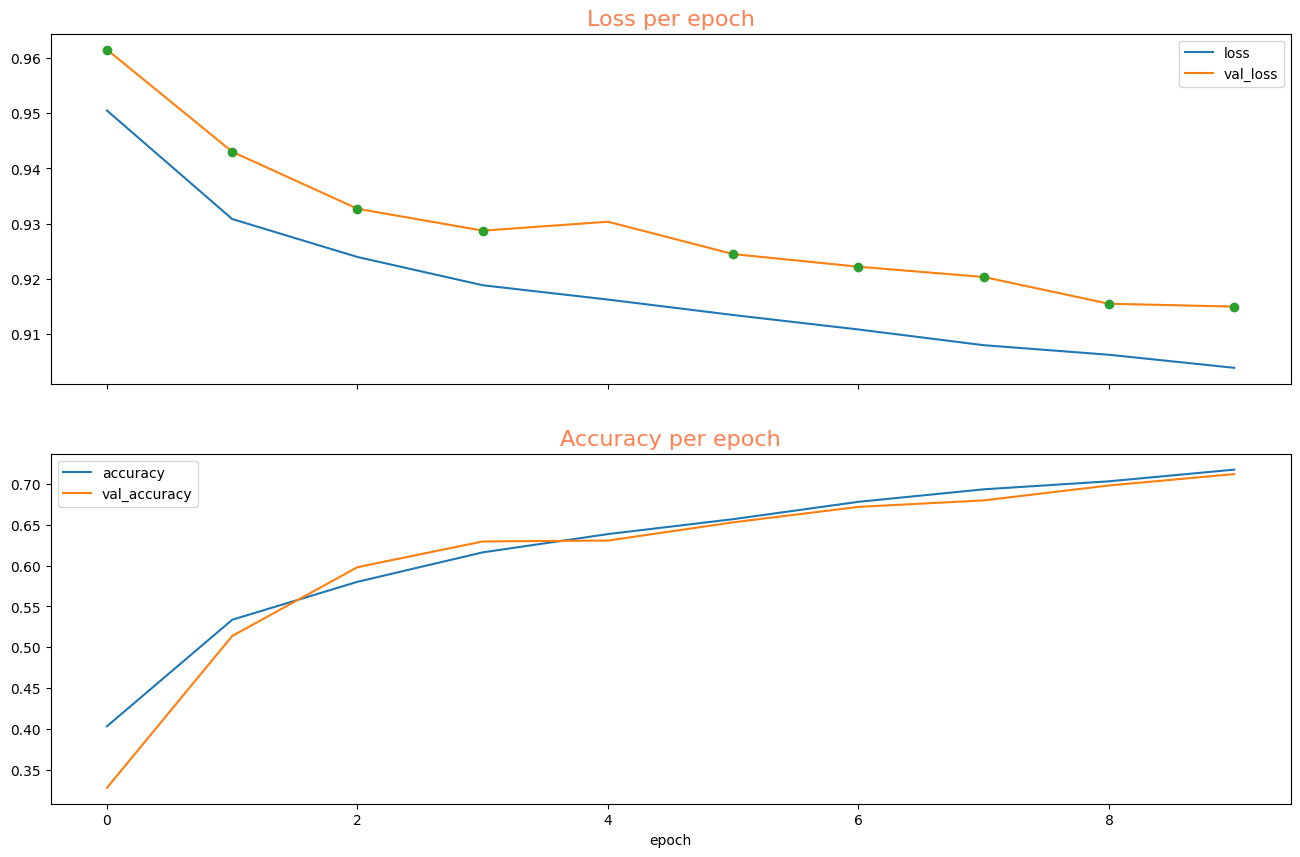

In [62]:
trainer.plot_training()

In [63]:
print("Training took {:.2f} seconds".format(trainer.total_duration))
print("Which is {:.2f} minutes".format(trainer.total_duration/60))

Training took 714.23 seconds
Which is 11.90 minutes


In [64]:
print(trainer.__dict__)
memo["trainer"]=trainer.__dict__
memo["trainer.epoch_count"]=trainer.epoch_count
memo["trainer.best_epoch"]=trainer.best_epoch
memo["trainer.best_value"]=trainer.best_value
memo["trainer.total_duration"]=trainer.total_duration

{'model_name': 'c:/Users/loren/Documents/Articles/github/Model_results/model=2024_06_11_TestA/model.json', 'weights_name': 'c:/Users/loren/Documents/Articles/github/Model_results/model=2024_06_11_TestA/model.h5', 'monitor': 'val_loss', 'model': <keras.src.engine.functional.Functional object at 0x000001E96E97EAD0>, 'history': <keras.src.callbacks.History object at 0x000001E99BFDC5B0>, 'Nb_epochs': 10, 'best_epoch': 9, 'durations': [78.91464567184448, 70.10996556282043, 72.09624099731445, 71.86406683921814, 69.424556016922, 67.8442530632019, 68.10779166221619, 72.72914433479309, 70.38877463340759, 72.75198173522949], 'total_duration': 714.2314205169678, 'loss_history': [0.9504719376564026, 0.9308398962020874, 0.9239739179611206, 0.9188636541366577, 0.9162698984146118, 0.9134774804115295, 0.9108585715293884, 0.9080163240432739, 0.9062857031822205, 0.9039244055747986], 'val_loss_history': [0.9614887237548828, 0.9430153965950012, 0.9327003955841064, 0.9287412762641907, 0.930351972579956, 0.

In [66]:
#save the memo and the parameters of the model
memo.to_csv(DIR_OUT+"/memo.csv")

# Testing


In [67]:
def load_model(Folder_out):

    # load json and create model
    json_file = open(Folder_out+"/model.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(Folder_out+"/model.h5")
    return loaded_model

In [68]:
#load the last model saved 
model=load_model(DIR_OUT)

In [72]:
def cut_full_slice(matrix,label, window_size):

    margin=int(0.1*window_size)
    stride=window_size-2*margin

    size=len(matrix)//stride-1
    nb_input=matrix.shape[1]

    X= np.empty([size,window_size,nb_input])
    Y= np.empty([size,window_size],dtype=int)

    for i in range(size):
        t=i*stride
        X[i,:,:]=matrix[t:t+window_size ,:]
        Y[i]=label[t:t+window_size]

    return X, Y

def stick(Y):

    window_size=Y.shape[1]
    margin=int(0.1*window_size)

    res=[]
    res.append(Y[0,:window_size-margin])

    for i in range(1,len(Y)):
        res.append(Y[i,margin:-margin])

    return np.concatenate(res,axis=0)

def save_predictions(turtle_names, window_size, save=True):

    for i,name in enumerate(turtle_names):
        matrix=Matrices[name]
        label=Labels[name]
        print(name,matrix.shape,label.shape)

        X_cut,Y_cut=cut_full_slice(matrix,label, window_size)
        Y_true=stick(Y_cut)

        #prediction
        Y_cut_pred_proba=model.predict([X_cut])
        Y_cut_pred=np.argmax(Y_cut_pred_proba,axis=2)

        Y_pred=stick(Y_cut_pred)
        Y_pred_proba=stick(Y_cut_pred_proba)

        print(name,matrix.shape,label.shape,Y_pred.shape)

        np.save(DIR_OUT+"/"+name+"=Y_pred",Y_pred)
        np.save(DIR_OUT+"/"+name+"=Y_pred_proba",Y_pred_proba)
        np.save(DIR_OUT+"/"+name+"=Y_true",Y_true)

In [73]:
#Apply the Vnet on all files and save the predictions
save_predictions(NAMES_ALL, WINDOW_SIZE)


CC-07-48_18-02-2019 (559219, 7) (559219,)
28/28 [==============================] - 3s 96ms/step
CC-07-48_18-02-2019 (559219, 7) (559219,) (558160,)
CC-07-48_06-10-2018 (475183, 7) (475183,)
24/24 [==============================] - 1s 34ms/step
CC-07-48_06-10-2018 (475183, 7) (475183,) (474320,)
CC-07-48_04-10-2018 (284021, 7) (284021,)
14/14 [==============================] - 0s 34ms/step
CC-07-48_04-10-2018 (284021, 7) (284021,) (282960,)
CC-07-115_13-05-2019 (731266, 7) (731266,)
36/36 [==============================] - 1s 34ms/step
CC-07-115_13-05-2019 (731266, 7) (731266,) (730320,)
CC-07-115_14-05-2019 (325009, 7) (325009,)
16/16 [==============================] - 1s 35ms/step
CC-07-115_14-05-2019 (325009, 7) (325009,) (323920,)
CC-07-48_08-04-2019_1 (157315, 7) (157315,)
8/8 [==============================] - 0s 31ms/step
CC-07-48_08-04-2019_1 (157315, 7) (157315,) (156240,)
CC-07-48_08-04-2019_2 (88800, 7) (88800,)
5/5 [==============================] - 0s 31ms/step
CC-07-48_08-

## PLot / Comparison

In [75]:
def get_all(turtle_names, matrices, labels, window_size):

    all_pred={}
    all_true={}

    for i,name in enumerate(turtle_names):
        matrix=matrices[name]
        label=labels[name]
        print(name,matrix.shape,label.shape)

        X_cut,Y_cut=cut_full_slice(matrix,label, window_size)
        Y_stick=stick(Y_cut)
        all_true[name]=Y_stick

        Y_cut_pred_proba=model.predict([X_cut])

        Y_cut_pred=np.argmax(Y_cut_pred_proba,axis=2)

        Y_stick_pred=stick(Y_cut_pred)
        all_pred[name]=Y_stick_pred

    return all_pred,all_true

In [76]:
all_pred,all_true=get_all(NAMES_ALL, Matrices, Labels, WINDOW_SIZE)

CC-07-48_18-02-2019 (559219, 7) (559219,)
28/28 [==============================] - 3s 95ms/step
CC-07-48_06-10-2018 (475183, 7) (475183,)
24/24 [==============================] - 1s 32ms/step
CC-07-48_04-10-2018 (284021, 7) (284021,)
14/14 [==============================] - 1s 36ms/step
CC-07-115_13-05-2019 (731266, 7) (731266,)
36/36 [==============================] - 1s 34ms/step
CC-07-115_14-05-2019 (325009, 7) (325009,)
16/16 [==============================] - 1s 35ms/step
CC-07-48_08-04-2019_1 (157315, 7) (157315,)
8/8 [==============================] - 0s 33ms/step
CC-07-48_08-04-2019_2 (88800, 7) (88800,)
5/5 [==============================] - 0s 27ms/step
CC-07-48_08-04-2019_3 (142801, 7) (142801,)
7/7 [==============================] - 0s 39ms/step
CC-07-48_22-05-2018 (286161, 7) (286161,)
14/14 [==============================] - 1s 35ms/step
CC-07-108_11-02-2019 (160292, 7) (160292,)
8/8 [==============================] - 0s 37ms/step
CC-07-59_20-05-2018 (423855, 7) (423855,)

In [77]:
def plot_categorical_vector(ax,vector,cat_selected,cat_names,markersize=2,color=None,label=None):


    for cat in cat_selected:
        ax.set_label("toto")
        here=(vector==cat)
        x_here=np.arange(len(vector))[here]
        y_here=cat*np.ones(len(vector))[here]
        line,=ax.plot(x_here, y_here,'o',markersize=markersize,color=color)


    line.set_label(label)

    ax.set_yticks(range(len(cat_selected)))
    ax.tick_params(colors='coral')
    labels=[]
    for cat in cat_selected:
        labels.append(str(cat)+":"+cat_names[cat])

    ax.set_yticklabels(labels)

In [78]:
def plot_compa_Y(ax,y,y_pred):

    nb_output=len(CLASSES)
    class_names=[CLASS.name for CLASS in CLASSES]


    plot_categorical_vector(ax,y,range(nb_output),class_names,markersize=3,color="blue",label="Y")
    plot_categorical_vector(ax,y_pred,range(nb_output),class_names,markersize=1,color="red",label="Y_pred")

    ax.legend()


In [79]:
def plot_compa(turtle_names,title,deb=0,fin=-1):
    #deb=0
    #fin=-1
    nb=len(turtle_names)
    fig,axs=plt.subplots(nb,1,figsize=(12,2*nb),sharex=False)
    if nb==1:axs=[axs]

    for i,name in enumerate(turtle_names):
        plot_compa_Y(axs[i],all_true[name][deb:fin],all_pred[name][deb:fin])
        axs[i].set_title(name, color="coral", fontsize=16)

    fig.tight_layout()

    fig.savefig(DIR_OUT+"/"+title+".png")

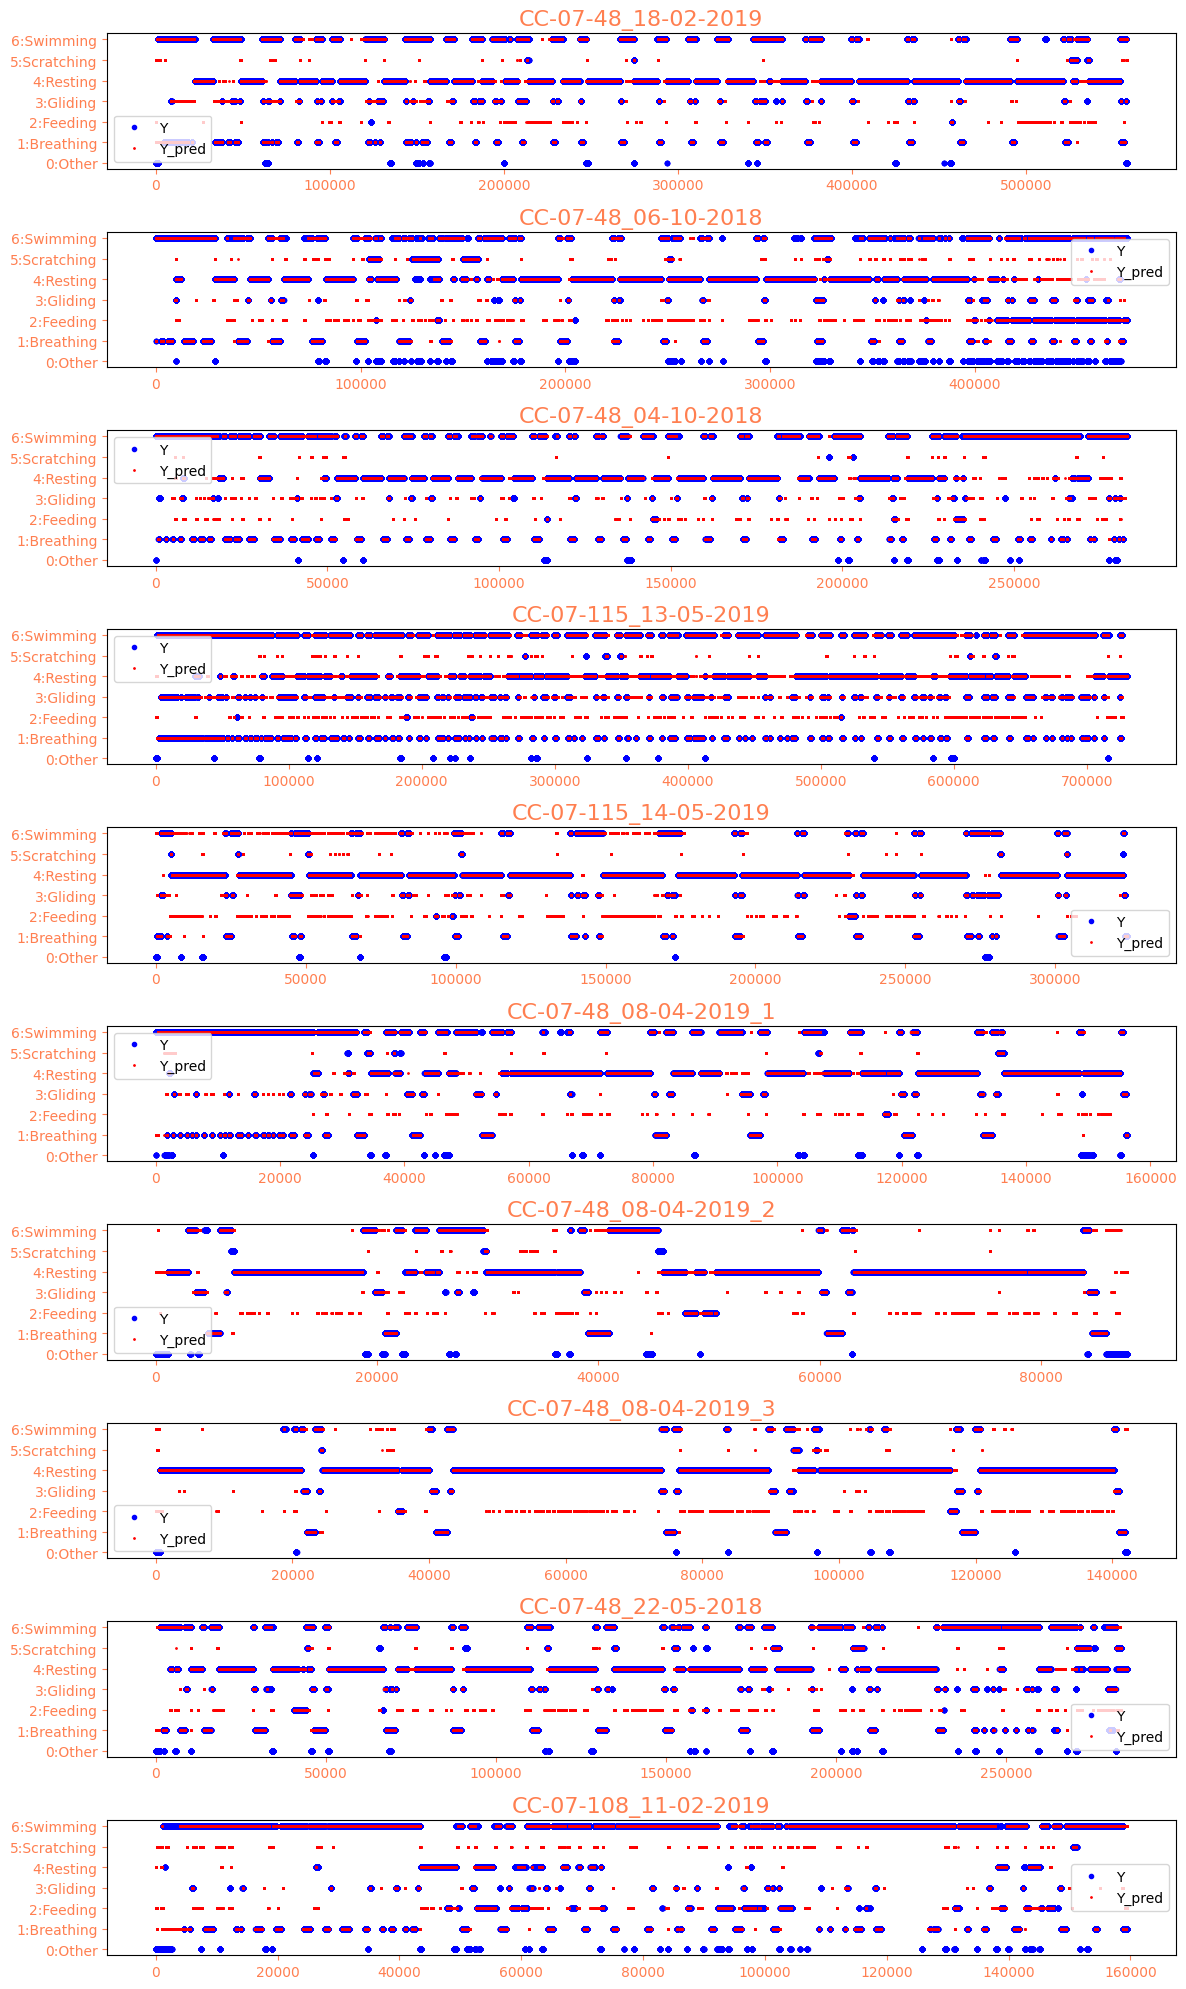

In [80]:
plot_compa(NAMES_TRAIN,"compa on train")

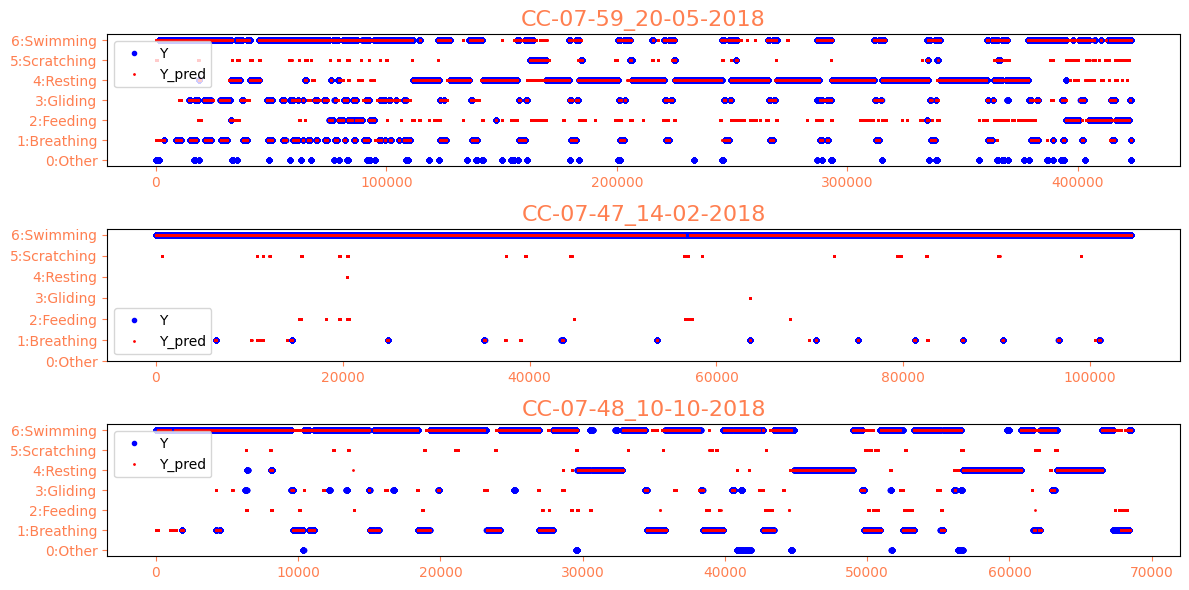

In [81]:
plot_compa(NAMES_VAL,"compa on val")

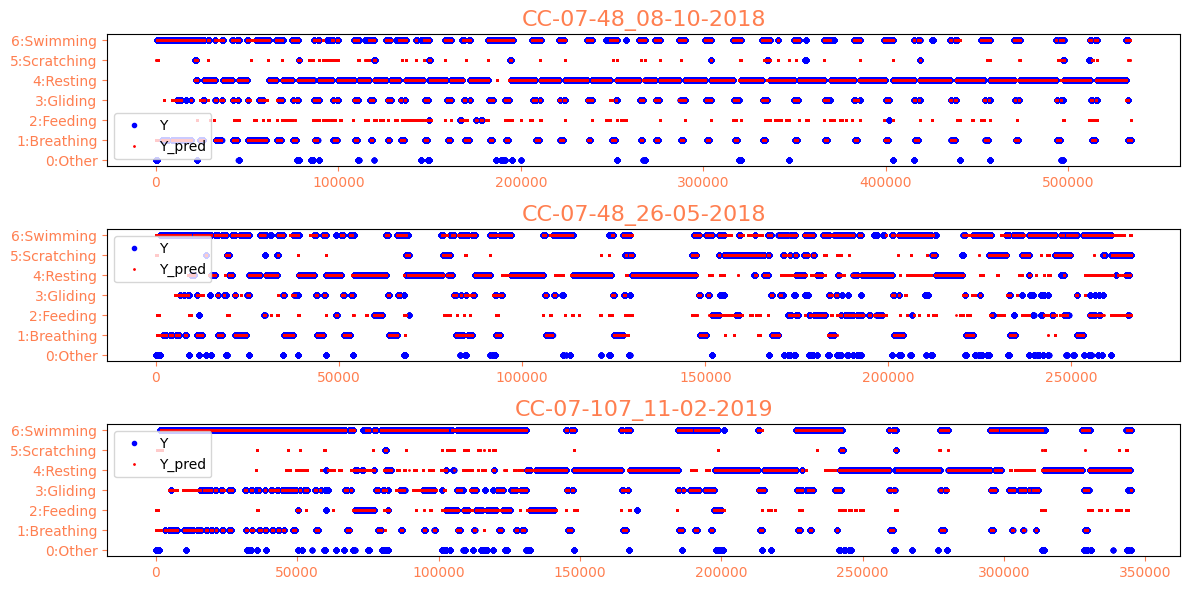

In [82]:
plot_compa(NAMES_TEST,"compa on test")

## Confusion Matrix


In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize,
                          title,
                          cmap="jet",
                          precision=2,
                         ):


    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)

    np.set_printoptions(precision=precision)


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    print("Confusion matrix, without normalization:")
    print(cm)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        print(cm)


    fig, ax = plt.subplots(figsize=(12,12))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.'+str(precision)+'f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "coral")
    fig.tight_layout()
    fig.savefig(DIR_OUT+"/"+title)



Confusion matrix, without normalization:
[[     0   2078   3977    626   2513   2335   5343]
 [     0  95346   1776   1305     34    700  11485]
 [     0      4  27055     48   2370   1333   1978]
 [     0    884    823  42765   4718    250   6121]
 [     0      0  13242     37 578059   2022    635]
 [     0    494   7334     10   1569  21816   4141]
 [     0   4498  11075  15515  23864   5359 240303]]
Normalized confusion matrix
[[0.   0.12 0.24 0.04 0.15 0.14 0.32]
 [0.   0.86 0.02 0.01 0.   0.01 0.1 ]
 [0.   0.   0.83 0.   0.07 0.04 0.06]
 [0.   0.02 0.01 0.77 0.08 0.   0.11]
 [0.   0.   0.02 0.   0.97 0.   0.  ]
 [0.   0.01 0.21 0.   0.04 0.62 0.12]
 [0.   0.01 0.04 0.05 0.08 0.02 0.8 ]]


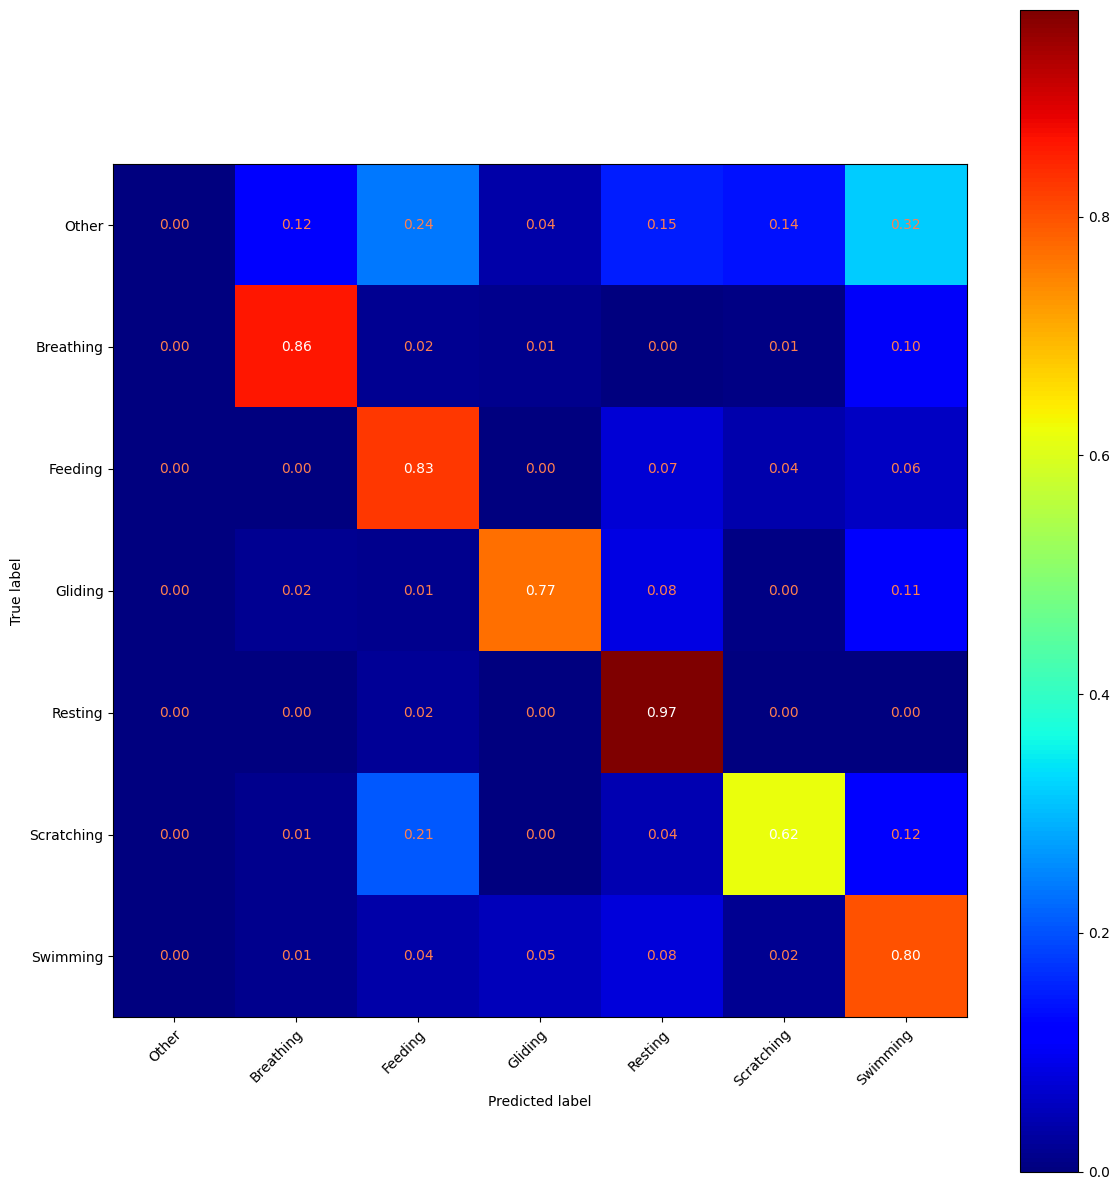

In [84]:
#calculate the confusion matrix only on the testing dataset
whole_true=[]
whole_pred=[]
for name in NAMES_TEST:
    whole_true.append(all_true[name])
    whole_pred.append(all_pred[name])

whole_true=np.concatenate(whole_true)
whole_pred=np.concatenate(whole_pred)
class_names=[CLASS.name for CLASS in CLASSES]

plot_confusion_matrix(whole_true,whole_pred, np.array(class_names),True,"whole validation")


In [85]:
#To calculate Precision,  Recall, Specificity and F1-score


cm = confusion_matrix(whole_true, whole_pred)

print(cm)
TP=np.diag(cm)
FP=np.sum(cm,axis=1)-TP
FN=np.sum(cm,axis=0)-TP
TN=np.ones(len(class_names))*np.sum(cm)-TP-FP-FN

Accuracy=(TP+TN)/(TP+TN+FP+FN)
Recall=TP/(TP+FN)
Precision =TP/(TP+FP)
Specificity =TN/(TN+FP)
F1_score=2*(Recall*Precision)/ (Recall+Precision)




[[     0   2078   3977    626   2513   2335   5343]
 [     0  95346   1776   1305     34    700  11485]
 [     0      4  27055     48   2370   1333   1978]
 [     0    884    823  42765   4718    250   6121]
 [     0      0  13242     37 578059   2022    635]
 [     0    494   7334     10   1569  21816   4141]
 [     0   4498  11075  15515  23864   5359 240303]]


C:\Users\loren\AppData\Local\Temp\ipykernel_13872\1032637477.py:13: RuntimeWarning: invalid value encountered in divide
  Recall=TP/(TP+FN)


In [89]:
df = pd.DataFrame({'Accuracy': Accuracy, 'Recall': Recall, 'Precision': Precision, 'Specificity': Specificity, 'F1_score': F1_score},
                      index = class_names)
df

,Accuracy,Recall,Precision,Specificity,F1_score
Other,0.985275,NaN,0.000000,0.985275,NaN
Breathing,0.979702,0.922965,0.861721,0.985324,0.891292
Feeding,0.961635,0.414433,0.825149,0.994694,0.551749
Gliding,0.973524,0.709133,0.769695,0.988212,0.738174
Resting,0.955488,0.942805,0.973171,0.970085,0.957747
Scratching,0.977705,0.645157,0.616899,0.987817,0.630712
Swimming,0.921443,0.889991,0.799374,0.931139,0.842252


In [90]:
Global_accuracy=(np.sum(TP)+np.sum(TN))/(np.sum(TP)+np.sum(TN)+np.sum(FP)+np.sum(FN))
print("Global Accuracy :", Global_accuracy)

Global Accuracy : 0.964967434994664


In [91]:
F1_score=np.mean(df['F1_score'][~np.isnan(df['F1_score'])])
print("F1-score :", F1_score)

F1-score : 0.7686544007493662
